In [1]:
import numpy as np
import os, cv2, torch, config
import matplotlib.pyplot as plt

#from REKD.evaluation.extract_hpatches import MultiScaleFeatureExtractor
from training.model.REKD import REKD, count_model_parameters

In [2]:
from sklearn.decomposition import NMF

In [3]:
args = config.get_config(jupyter=True)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
args.load_dir =  'trained_models/release_group36_f2_s2_t2.log/best_model.pt'


model = REKD(args, device)
model.load_state_dict(torch.load(args.load_dir, map_location=torch.device('cpu')))  ## Load the PyTorch learnable model parameters.

model.export()
model.eval()
model = model.to(device) ## use GPU


print("Model paramter : {} is loaded.".format( args.load_dir ))
count_model_parameters(model)

/home/joon/anaconda3/envs/rekd/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343895737/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model paramter : trained_models/release_group36_f2_s2_t2.log/best_model.pt is loaded.
================ List of Learnable model parameters ================ 
block1.0.weight torch.Size([72, 1, 5, 5])
block1.1.weight torch.Size([72])
block1.1.bias torch.Size([72])
block2.0.weight torch.Size([72, 72, 5, 5])
block2.1.weight torch.Size([72])
block2.1.bias torch.Size([72])
block3.0.weight torch.Size([72, 72, 5, 5])
block3.1.weight torch.Size([72])
block3.1.bias torch.Size([72])
ori_learner.0.weight torch.Size([36, 72, 1, 1])
last_layer_learner.0.weight torch.Size([6])
last_layer_learner.0.bias torch.Size([6])
last_layer_learner.1.weight torch.Size([1, 6, 1, 1])
last_layer_learner.1.bias torch.Size([1])
block1.0.weight torch.Size([72, 1, 5, 5])
block1.1.weight torch.Size([72])
block1.1.bias torch.Size([72])
block2.0.weight torch.Size([72, 72, 5, 5])
block2.1.weight torch.Size([72])
block2.1.bias torch.Size([72])
block3.0.weight torch.Size([72, 72, 5, 5])
block3.1.weight torch.Size([72])
block3

In [4]:
print(device)

cpu


In [5]:
image_path1 = os.path.join(os.getcwd(), "images/sample.jpg")

img1 = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)[np.newaxis, :, :]  ## (1, H, W)
img1 = img1.astype(float) / img1.max()

In [6]:
img1 = torch.Tensor(img1)

img1.shape

torch.Size([1, 576, 720])

In [7]:
img1 = torch.tensor(img1).unsqueeze(0).to(torch.float32)
im_scores, ori_map = model(img1)

/tmp/ipykernel_739/2810478061.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1 = torch.tensor(img1).unsqueeze(0).to(torch.float32)


In [30]:
kp1 = kp1 / kp1.max()
heatmap = cv2.applyColorMap(np.uint8(255 * kp1), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255
#img_vis = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)
img_ = np.float32(img1.squeeze(0).permute(1, 2, 0)) #/ 255
_attended_img = heatmap + np.float32(img_)
attended_img = _attended_img / np.max(_attended_img)

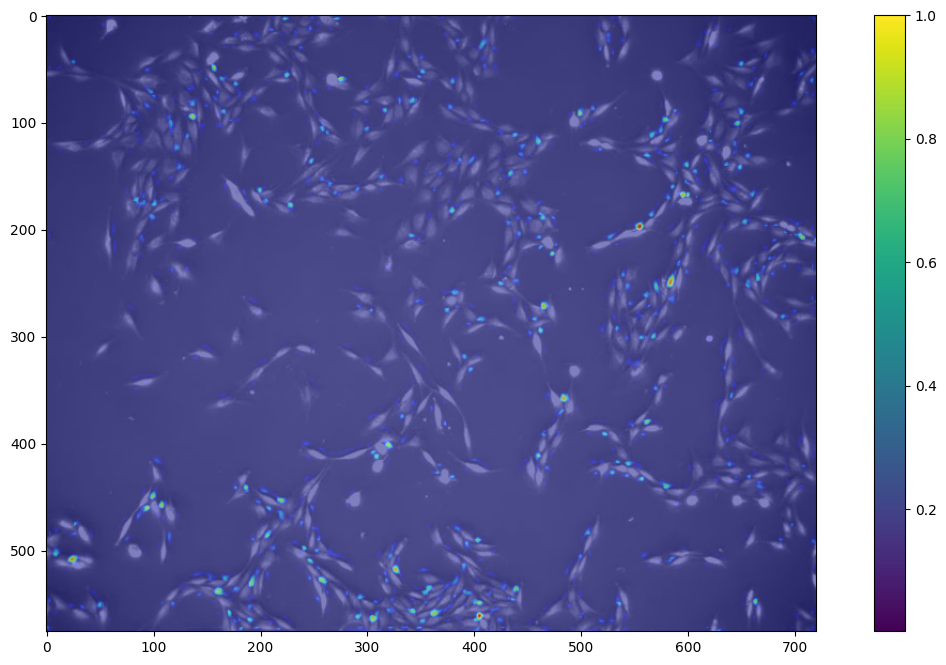

In [31]:
plt.figure(figsize=(15,8))
plt.imshow(np.clip(attended_img, 0, 1))
plt.colorbar()

In [8]:
print(ori_map.shape)

torch.Size([1, 36, 576, 720])


In [10]:
bin_size, h, w = ori_map.shape[1:]
ori_vals = torch.argmax(ori_map, dim=1) * 360 / bin_size 

In [11]:
ori_vals = ori_vals / ori_vals.max()
ori_heatmap = cv2.applyColorMap(np.uint8(255 * ori_vals.squeeze()), cv2.COLORMAP_HSV)
#ori_heatmap = cv2.cvtColor(ori_heatmap, cv2.COLOR_BGR2HSV)
#ori_heatmap = np.float32(ori_heatmap) / 255
#img_vis = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)
img_2_ = np.float32(img1.squeeze(0).permute(1, 2, 0)) #/ 255
_ori_attended_img = ori_heatmap + np.float32(img_2_)
ori_attended_img = _ori_attended_img / np.max(_ori_attended_img)

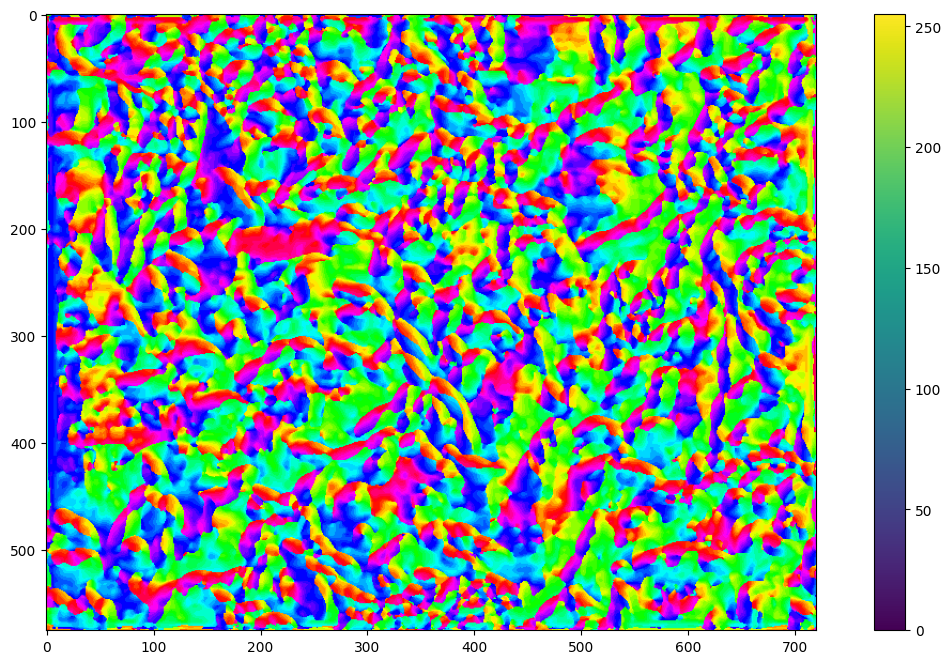

In [12]:
plt.figure(figsize=(15,8))
plt.imshow(ori_heatmap)
plt.colorbar()

In [16]:
img_patch1 = img1[:,:,:100,:100]
img_patch2 = img1[:,:,101:201,101:201]
_,_,h1,w1 = img_patch1.shape
_,_,h2,w2 = img_patch2.shape
print(h1 == h2)

True


In [17]:
B, C, H, W = img_patch1.shape
sample_ran = np.linalg.norm(img_patch1.detach().numpy().reshape(H*W, C), axis=1)
sample_ran.shape

(10000,)

In [14]:
x_1 = np.array([[2,3, 5], [4,5, 8]])
x_2 = np.array([[1,9], [2,0], [4,4]])
y = np.matmul(x_1, x_2)
print(y)
print(x_1.shape)

[[28 38]
 [46 68]]
(2, 3)


In [18]:
random_image = np.matmul(sample_ran[:, np.newaxis], np.transpose(sample_ran[:, np.newaxis]))
print(random_image.shape)


(10000, 10000)


In [47]:
def self_similarity(img):
    
    im = img.detach().numpy()
    C, H, W = im.squeeze().shape
    im_flatten = im.reshape(H*W, C)
    im_mag = np.matmul(np.linalg.norm(im_flatten, axis=1), np.linalg.norm(im_flatten, axis=1).T)
    cos_sim = np.matmul(im_flatten, im_flatten.T)

    return {"H": W, "W": W, "kernel": cos_sim / im_mag}


def gaussian_self_similarity(img):
    
    im = img.detach().numpy()
    C, H, W = im.squeeze().shape
    im_flatten = im.reshape(H*W, C)
    output = np.zeros((H*W, H*W))
    variance = 0.0067
    for i in range(H*W):
        for j in range(H*W):
            output[i,j] = np.exp(-1 * np.linalg.norm(im_flatten[i, :] - im_flatten[j, :])**2 / (2 * variance))

            

    return {"H": W, "W": W, "kernel": output}
    


In [48]:
kernel = gaussian_self_similarity(ori_map[:,:,:100,:100])


In [49]:
kernel["kernel"].shape

(10000, 10000)

In [53]:

def nmf_prep(activations):
    data = None
    assert len(activations) != 0
    if len(activations) == 1:
        print("Need at least two activation maps in list!")
        return
    print("Length of activation list: ", len(activations))
    b, c, h, w = activations[0].shape
    #loop initial condition, terminating condition, and invariant - always think of these
    #array[i] (op) array[i+1] usually results in a error due to the terminating condition at the end
    for i in range(len(activations)-1):
        if i == 0:
            data = torch.cat([activations[i].squeeze().reshape(h*w, c), activations[i+1].squeeze().reshape(h*w, c)], dim = 0)
        else:
            data = torch.cat([data, activations[i+1].squeeze().reshape(h*w, c)], dim = 0)

    return data

#data must be a torch tensor
def apply_nmf(data, k):
    nmf_input = None
    if type(data) == torch.Tensor:
        nmf_input = data.detach().numpy()
    else:
        nmf_input = data
    nmf = NMF(n_components=k, max_iter=500)
    H = nmf.fit_transform(nmf_input)
    W = nmf.components_
    return H, W

def display_patches(img_list): #receives a list of torch tensors as input
    fig = plt.figure()
    for i in range(len(img_list)):
        im = img_list[i]
        if type(im) == torch.Tensor:
            im = im.numpy()
        fig.add_subplot(1,len(img_list),i+1)
        plt.imshow(im)

    plt.show()
    return



In [56]:
import time as _time
from BEAR.bear.BEAR import BEAR
from BEAR.bear.options_ipynb import parse

In [61]:
print(torch.version.cuda)
print(torch.cuda.is_available())

None
False


In [60]:
# Do BEAR

args = parse()

# Set hyperparameters for BEAR
args.lr = 1e-3
args.epoch = 80
args.rank = 1
args.batch_size = 64
args.device = 'cuda:0'

Y_res = torch.from_numpy(kernel["kernel"]).to(torch.float32)

print(f"""
START TIME : {_time.strftime("%Y-%m-%d %H:%M:%S", _time.localtime())}
T_XY SHAPE : {Y_res.size()}
CONFIG     : {args}""")

[L_res, S_res, total_loss, _, time] = BEAR(Y_res, args)

print(f"""Finished. Elapsed time : {time}, Total Loss : {total_loss:.3f}""")

options_ipynb mode

START TIME : 2023-08-16 18:23:38
T_XY SHAPE : torch.Size([10000, 10000])
CONFIG     : Namespace(D=None, alpha=0.001, batch_size=64, bear_type='wwt', constrain_L=None, constrain_S=None, d=None, delta=0, device='cuda:0', early_stop=True, epoch=80, lr=0.001, rank=1, sparse_NMF=None, tensorboard=False, verbose=False)


AssertionError: Torch not compiled with CUDA enabled

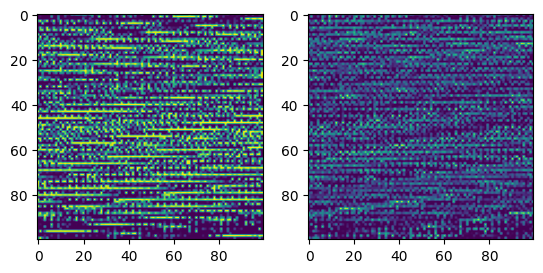

In [54]:

H, W = apply_nmf(kernel["kernel"], 2)
#### k = 2:
map1 = H[:,0].reshape(kernel["H"], kernel["W"])
map2 = H[:,1].reshape(kernel["H"], kernel["W"])
display_patches([map1, map2])

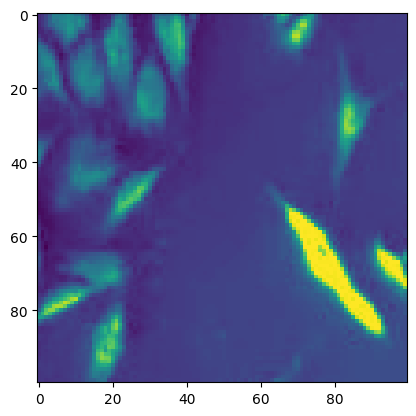

In [52]:
display_patches([img_patch2.squeeze()])

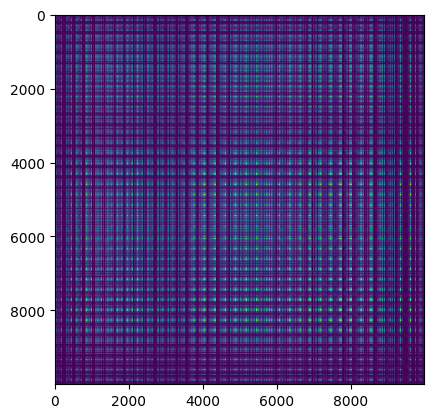

In [50]:
display_patches([kernel["kernel"].squeeze()])

In [10]:
num_patches = 3

patch_size = 100
img_patches = []
#maintain img patches as torch tensors
for i in range(num_patches):
    img_patches.append(img1[:,:,patch_size*i:patch_size*(i+1),patch_size*i:patch_size*(i+1)].squeeze())
    if i > 0:
        assert img_patches[i-1].shape == img_patches[i].shape

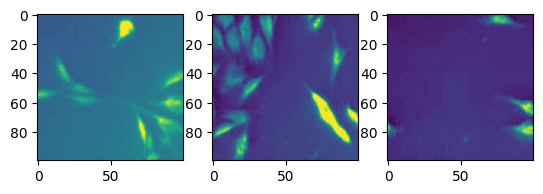

In [11]:
def display_patches(img_list): #receives a list of torch tensors as input
    fig = plt.figure()
    for i in range(len(img_list)):
        im = img_list[i]
        if type(im) == torch.Tensor:
            im = im.numpy()
        fig.add_subplot(1,len(img_list),i+1)
        plt.imshow(im)

    plt.show()
    return

display_patches(img_patches)

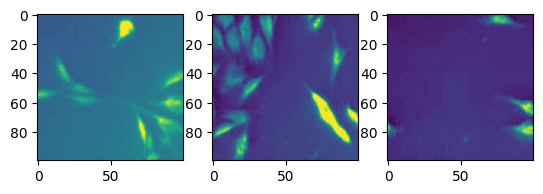

In [12]:
#Try flattening and un-flattening:
img_test_list = []
for i in range(len(img_patches)):
    img_test = img_patches[i]
    h,w = img_test.squeeze().shape
    img_test = img_test.numpy().reshape(h*w)
    img_test_list.append(img_test.reshape(h,w))


display_patches(img_test_list)
    

In [71]:
#return a list of all python elements
def model_activations(model, imgs_list):
    model_activations = torch.nn.Sequential(model.block1, model.block2, model.block3)
    activation_list = []
    for i in range(len(imgs_list)):
        activation_list.append(model_activations(imgs_list[i].unsqueeze(0).unsqueeze(0)))
        if i > 0:
            assert activation_list[i-1].shape == activation_list[i].shape
    return activation_list

activations = model_activations(model, img_patches)

In [ ]:
##Do orientations of sift keypoints point towards a common center???

In [81]:

def nmf_prep(activations):
    data = None
    assert len(activations) != 0
    if len(activations) == 1:
        print("Need at least two activation maps in list!")
        return
    print("Length of activation list: ", len(activations))
    b, c, h, w = activations[0].shape
    #loop initial condition, terminating condition, and invariant - always think of these
    #array[i] (op) array[i+1] usually results in a error due to the terminating condition at the end
    for i in range(len(activations)-1):
        if i == 0:
            data = torch.cat([activations[i].squeeze().reshape(h*w, c), activations[i+1].squeeze().reshape(h*w, c)], dim = 0)
        else:
            data = torch.cat([data, activations[i+1].squeeze().reshape(h*w, c)], dim = 0)

    return data

data = nmf_prep(activations)
print(data.shape)


Length of activation list:  3
torch.Size([30000, 72])


In [83]:
type(data)

torch.Tensor

In [85]:
type(img_patches[0].numpy())

numpy.ndarray

In [86]:
#data must be a torch tensor
def apply_nmf(data, k):
    nmf_input = None
    if type(data) == torch.Tensor:
        nmf_input = data.detach().numpy()
    nmf = NMF(n_components=k, max_iter=99)
    H = nmf.fit_transform(nmf_input)
    W = nmf.components_
    return H, W
        
H, W = apply_nmf(data, 2)


/Users/joonpark/anaconda3/envs/rekd/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 99 reached. Increase it to improve convergence.
  warnings.warn(


In [87]:
print(H.shape)

(30000, 2)


In [104]:
#output: list of images

def unpack_heatmaps(H, h, w): #input: H from HW of NMF
    n_h_w, k = H.shape
    num_imgs = n_h_w // (h*w)

    f = lambda x : x.reshape(h,w, k)
    heatmap_list = [f(H[i*h*w:(i+1)*h*w,:]) for i in range(num_imgs)]

    print(len(heatmap_list))
    return heatmap_list
    
hm_list = unpack_heatmaps(H, patch_size, patch_size)

3


In [110]:
print(hm_list[0].shape)
hm_list_1 = [hm[:,:,0] for hm in hm_list]
print(hm_list_1[0].shape)
hm_list_2 = [hm[:,:,1] for hm in hm_list]
print(hm_list_1[0].shape)


(100, 100, 2)
(100, 100)
(100, 100)


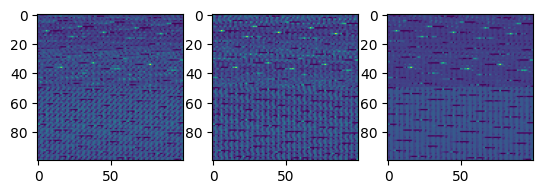

In [108]:
display_patches(hm_list_1)

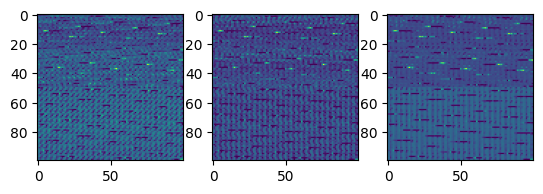

In [111]:
display_patches(hm_list_2)


In [30]:
x = model.block1(img_patch1)
x = model.block2(x)
x = model.block3(x)

y = model.block1(img_patch2)
y = model.block2(y)
y = model.block3(y)

print("x's shape is:", x.shape)
print("y's shape is:", y.shape)


x's shape is: torch.Size([1, 72, 100, 100])
y's shape is: torch.Size([1, 72, 100, 100])


In [41]:
b, c, h, w = x.shape
data = torch.cat([x.squeeze().reshape(h*w, c), y.squeeze().reshape(h*w, c)], dim = 0)
print(data.shape)


torch.Size([20000, 72])


In [44]:
nb_patterns = 2
nmf = NMF(n_components=nb_patterns, max_iter=99)
H = nmf.fit_transform(data.detach().numpy())
W = nmf.components_

/Users/joonpark/anaconda3/envs/rekd/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 99 reached. Increase it to improve convergence.
  warnings.warn(


In [51]:
print(H.shape)
print(W.shape)
for i in range(nb_patterns):
    interval = H.shape[0]//nb_components
    hm_i = H[i*interval:(i+1)*interval,:]
    # hm_1 = hm_1.reshape(h,w, nb_patterns)
    # hm_2 = H[H.shape[0]//2:,:]
    # hm_2 = hm_2.reshape(h,w, nb_patterns)
print(hm_1.shape)
print(hm_2.shape)

(20000, 2)
(2, 72)
(100, 100, 2)
(10000, 2)


In [ ]:
x_heatmap, y_heatmap = torch.unbind(nmf_output, dim=1)

In [ ]:

#
def display_heatmap_overlay(imgs, heatmaps): #lists of images and heatmaps
    num1 = len(imgs)
    num2 = len(heatmaps)
    assert num1 == num2
    h, w = imgs[0].shape

    fig = plt.figure()
    for i in range(num1):
        im = imgs[i]
        hm = heatmaps[i]
        hm = hm / hm.max()
        heatmap = cv2.applyColorMap(np.uint8(255 * hm), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255
        img_ = np.float32(im.squeeze(0).permute(1, 2, 0)) #/ 255


        for i in range(1,20):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(i,2,1)
    plt.imshow(img)
plt.show()


kp1 = kp1 / kp1.max()
heatmap = cv2.applyColorMap(np.uint8(255 * kp1), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255
#img_vis = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)
img_ = np.float32(img1.squeeze(0).permute(1, 2, 0)) #/ 255
_attended_img = heatmap + np.float32(img_)
attended_img = _attended_img / np.max(_attended_img)

plt.figure(figsize=(15,8))
plt.imshow(np.clip(attended_img, 0, 1))
plt.colorbar()

In [ ]:
x.squeeze().reshape()

In [6]:
#img1 = torch.transpose(img1, 0, 1)
#img1 = torch.transpose(img1, 0, 2)

#img1.shape

torch.Size([3, 576, 720])

In [8]:
x = img1.unsqueeze(0)
x = x.unsqueeze(0)
x = x.cuda()
x.shape

torch.Size([1, 1, 576, 720])

In [ ]:
def _extract_features(self, path, model1):
        image = self.read_image(path)

        score_maps, ori_maps = self._compute_score_maps(image, model1)

        im_pts = self._estimate_keypoint_coordinates(score_maps)

        im_pts, ori_values = self._estimate_orientations(im_pts, ori_maps)

        descriptors = self._extract_descriptors(image, im_pts)

        return im_pts, descriptors, ori_values

In [9]:
features_key, features_ori = model(x)


: 

: 